In [1]:

!pip install -q kaggle

from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jagatheghost","key":"0aceb29784a5d9ba732f87653606ba2c"}'}

In [2]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip -q breast-histopathology-images.zip -d IDC_dataset


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:51<00:00, 220MB/s]
100% 3.10G/3.10G [00:51<00:00, 64.9MB/s]


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Organize Images from Subfolders into One Flat Folder Per Class
import os
import shutil
from tqdm import tqdm

# Input dataset folder (raw nested)
source_dir = '/content/IDC_dataset'
# Output organized dataset folder
output_dir = '/content/IDC_dataset/organised'

# Create class folders if they don't exist
os.makedirs(os.path.join(output_dir, '0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, '1'), exist_ok=True)

# Flattening images into /0/ and /1/
for folder in tqdm(os.listdir(source_dir)):
    subfolder_path = os.path.join(source_dir, folder)
    if os.path.isdir(subfolder_path):
        for class_label in ['0', '1']:
            class_folder = os.path.join(subfolder_path, class_label)
            if os.path.isdir(class_folder):
                for img_file in os.listdir(class_folder):
                    src = os.path.join(class_folder, img_file)
                    dst = os.path.join(output_dir, class_label, f"{folder}_{img_file}")
                    shutil.copy(src, dst)

print("Dataset organized into class 0 and 1 folders.")


100%|██████████| 282/282 [03:59<00:00,  1.18it/s]

Dataset organized into class 0 and 1 folders.


In [6]:
# Load and Preprocess the Data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Dataset path
dataset_path = '/content/IDC_dataset/organised'

# Image preprocessing
img_size = 50
batch_size = 64

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 385768 images belonging to 2 classes.
Found 96441 images belonging to 2 classes.


In [7]:
# Define the CNN (CancerNet)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,881 (3.86 MB)

 Trainable params: 1,010,881 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the Model
epochs = 25

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen
)


Epoch 1/25
 750/6028 ━━━━━━━━━━━━━━━━━━━━ 22:35 257ms/step - accuracy: 0.8945 - loss: 0.2566

KeyboardInterrupt: 

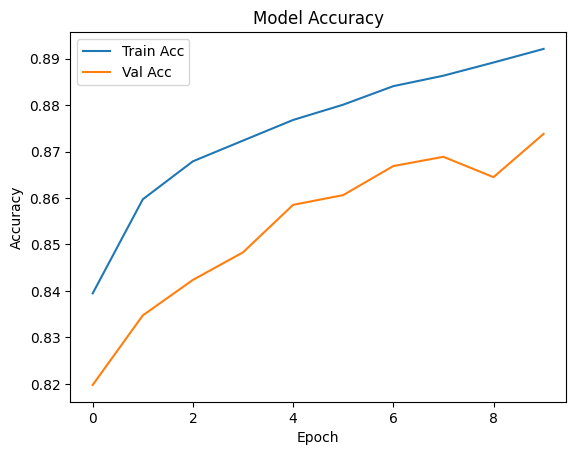

1507/1507 ━━━━━━━━━━━━━━━━━━━━ 118s 78ms/step


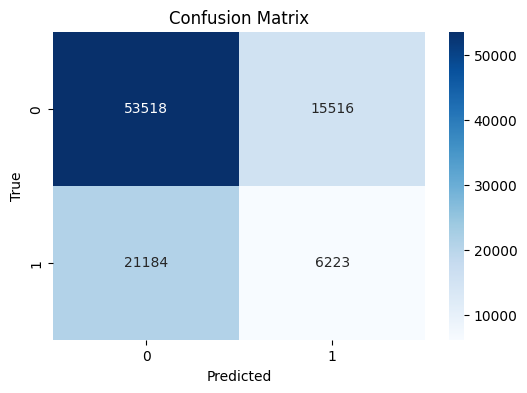

              precision    recall  f1-score   support

      Benign       0.72      0.78      0.74     69034
   Malignant       0.29      0.23      0.25     27407

    accuracy                           0.62     96441
   macro avg       0.50      0.50      0.50     96441
weighted avg       0.59      0.62      0.61     96441



In [11]:
# Evaluate and Visualize
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion Matrix
val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds > 0.5).astype("int32")
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))
